# Importing Libraries and modules


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform, exposure
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2



# Define path of signatures

In [2]:
genuine_image_path = r"C:\Users\divis\OneDrive\Documents\Signature-Verification-using-machine-learning-main\real"
forged_image_path = r"C:\Users\divis\OneDrive\Documents\Signature-Verification-using-machine-learning-main\forged"

# Preprocessing the image

In [3]:
def load_and_preprocess_images(genuine_path, forged_path):
    data = []
    labels = []
    
    for file in os.listdir(genuine_path):
        if file.endswith(".png"):
            img = io.imread(os.path.join(genuine_path, file), as_gray=True)
            # Enhanced preprocessing
            img = exposure.equalize_adapthist(img)  # Contrast enhancement
            img = transform.resize(img, (128, 128))
            img = (img - np.mean(img)) / np.std(img)  # Normalization
            data.append(img)
            labels.append(1)
    
    for file in os.listdir(forged_path):
        if file.endswith(".png"):
            img = io.imread(os.path.join(forged_path, file), as_gray=True)
            img = exposure.equalize_adapthist(img)
            img = transform.resize(img, (128, 128))
            img = (img - np.mean(img)) / np.std(img)
            data.append(img)
            labels.append(0)
    
    data = np.array(data)
    data = data.reshape((data.shape[0], 128, 128, 1))
    labels = np.array(labels)
    
    return data, labels


In [4]:
def create_data_generator():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest'
    )

## Define the CNN model

In [5]:
# Improved CNN model
def create_improved_model(input_shape):
    model = Sequential([
        GaussianNoise(0.1, input_shape=input_shape),
        
        # First Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Conv Block
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Dense Layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
  


In [6]:

input_shape = (128, 128, 1)  # Matches preprocessed image shape in the notebook
model = create_improved_model(input_shape)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNo  (None, 128, 128, 1)       0         
 ise)                                                            
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                      

# Train the model

In [7]:
from sklearn.model_selection import train_test_split


data, labels = load_and_preprocess_images(genuine_image_path, forged_image_path)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

#early stopping
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True 
)


history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],   
    verbose=1
)


Epoch 1/100


5/5 [==============================] - 74s 12s/step - loss: 3.1677 - accuracy: 0.4747 - val_loss: 2.7567 - val_accuracy: 0.5250
Epoch 2/100
5/5 [==============================] - 58s 12s/step - loss: 2.7042 - accuracy: 0.6899 - val_loss: 2.7572 - val_accuracy: 0.5250
Epoch 3/100
5/5 [==============================] - 42s 8s/step - loss: 2.5962 - accuracy: 0.7722 - val_loss: 2.7609 - val_accuracy: 0.5250
Epoch 4/100
5/5 [==============================] - 58s 12s/step - loss: 2.5959 - accuracy: 0.7468 - val_loss: 2.7717 - val_accuracy: 0.5250
Epoch 5/100
5/5 [==============================] - 60s 12s/step - loss: 2.4486 - accuracy: 0.8165 - val_loss: 2.7907 - val_accuracy: 0.5250
Epoch 6/100
5/5 [==============================] - 24s 4s/step - loss: 2.3705 - accuracy: 0.8544 - val_loss: 2.8159 - val_accuracy: 0.5250


# Plot learning curve for model

In [12]:
import matplotlib.pyplot as plt

def plot_train_vs_test(history):
    # Accuracy
    plt.figure(figsize=(12,5))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()


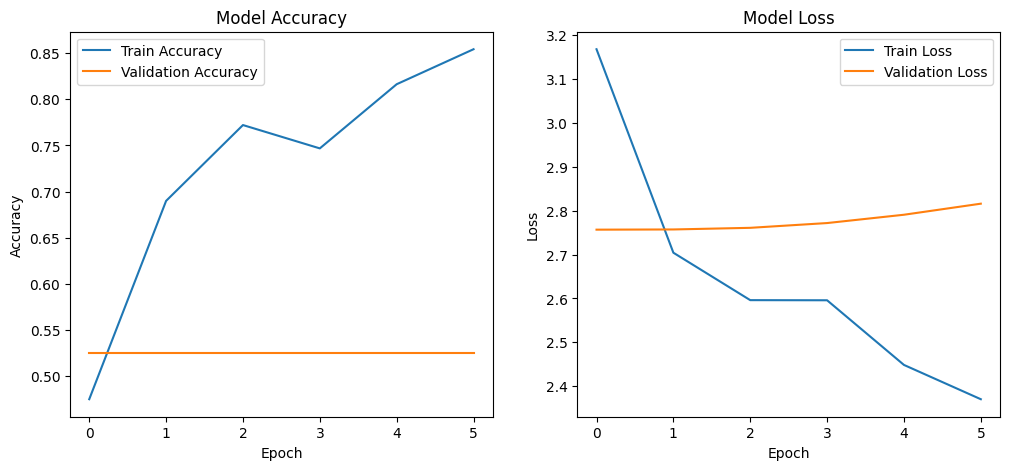

In [13]:
plot_train_vs_test(history)


# Test  and evaluate the Model

In [11]:
def predict_signature(model, img_path):
    img = io.imread(img_path, as_gray=True)
    img = transform.resize(img, (128, 128))
    img = np.array(img)
    img = img.reshape((1, 128, 128, 1))
    prediction = model.predict(img)
    print("Accuracy: ", prediction)
    return prediction[0][0] > 0.5

# Test the model with an example
# person_id = "001"
# image_path = "C:\\Users\\Divish\\Desktop\\Dataset2\\test\\001_001_000.png"
# result = predict_signature(model, image_path)
# print("Genuine" if result else "Forged")

# Function to evaluate model's accuracy on test data
def evaluate_model_accuracy(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test accuracy:", test_accuracy)

evaluate_model_accuracy(model, X_test, y_test)

# User input for person_id and image_path
person_id = input("Enter person ID (e.g., 001): ")
image_path = input("Enter image path (e.g., C:\\Users\\Divish\\Desktop\\Dataset2\\real\\001001_000.png): ")

# validating person_id and image_path
# while True:
#     person_id = input("Enter person ID (e.g., 001): ")
#     if person_id.isdigit() and 1 <= int(person_id) <= 20 and len(person_id) == 3:
#         break
#     else:
#         print("Person ID should be a number between 001 to 020.")

# while True:
#     image_path = input("Enter image path (e.g., C:\\Users\\Divish\\Desktop\\Dataset2\\real\\001001_000.png): ")
#     if os.path.exists(image_path):
#         filename = os.path.basename(image_path)
#         parts = filename.split("_")
#         if len(parts) == 2:
#             yyy = parts[0][-3:]
#             zzz = parts[1][:-4]
#             if yyy == person_id and zzz.isdigit() and 0 <= int(zzz) <= 4:
#                 if "real" in image_path or "forged" in image_path:
#                     if int(person_id) <= 20 and yyy in ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010", "011", "012", "013", "014", "015", "016", "017", "018", "019", "020", "021"]:
                            #break

result = predict_signature(model, image_path)
print("Genuine" if result else "Forged")

2/2 [==============================] - 1s 106ms/step - loss: 2.7567 - accuracy: 0.5250
Test accuracy: 0.5249999761581421
1/1 [==============================] - 0s 256ms/step
Accuracy:  [[0.47657767]]
Forged
